In [49]:
# Intended to be run via a virtual environment with the packages
# in ../../requirements.txt installed.

import numpy as np
import pandas as pd
import qspems
import matplotlib.pyplot as plt
import networkx as nx

from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

import graphinference.libs.qspems_sim_core as qspems_sim_core

import statsmodels
from statsmodels.tsa.api import VAR

### Investigating Pairwise Edge Measures: 

**Lagged correlation corrected for confounding factors** method taken from

Schwartze et. al. *Network inference via process motifs for lagged correlation in linear stochastic processes*
(2022)

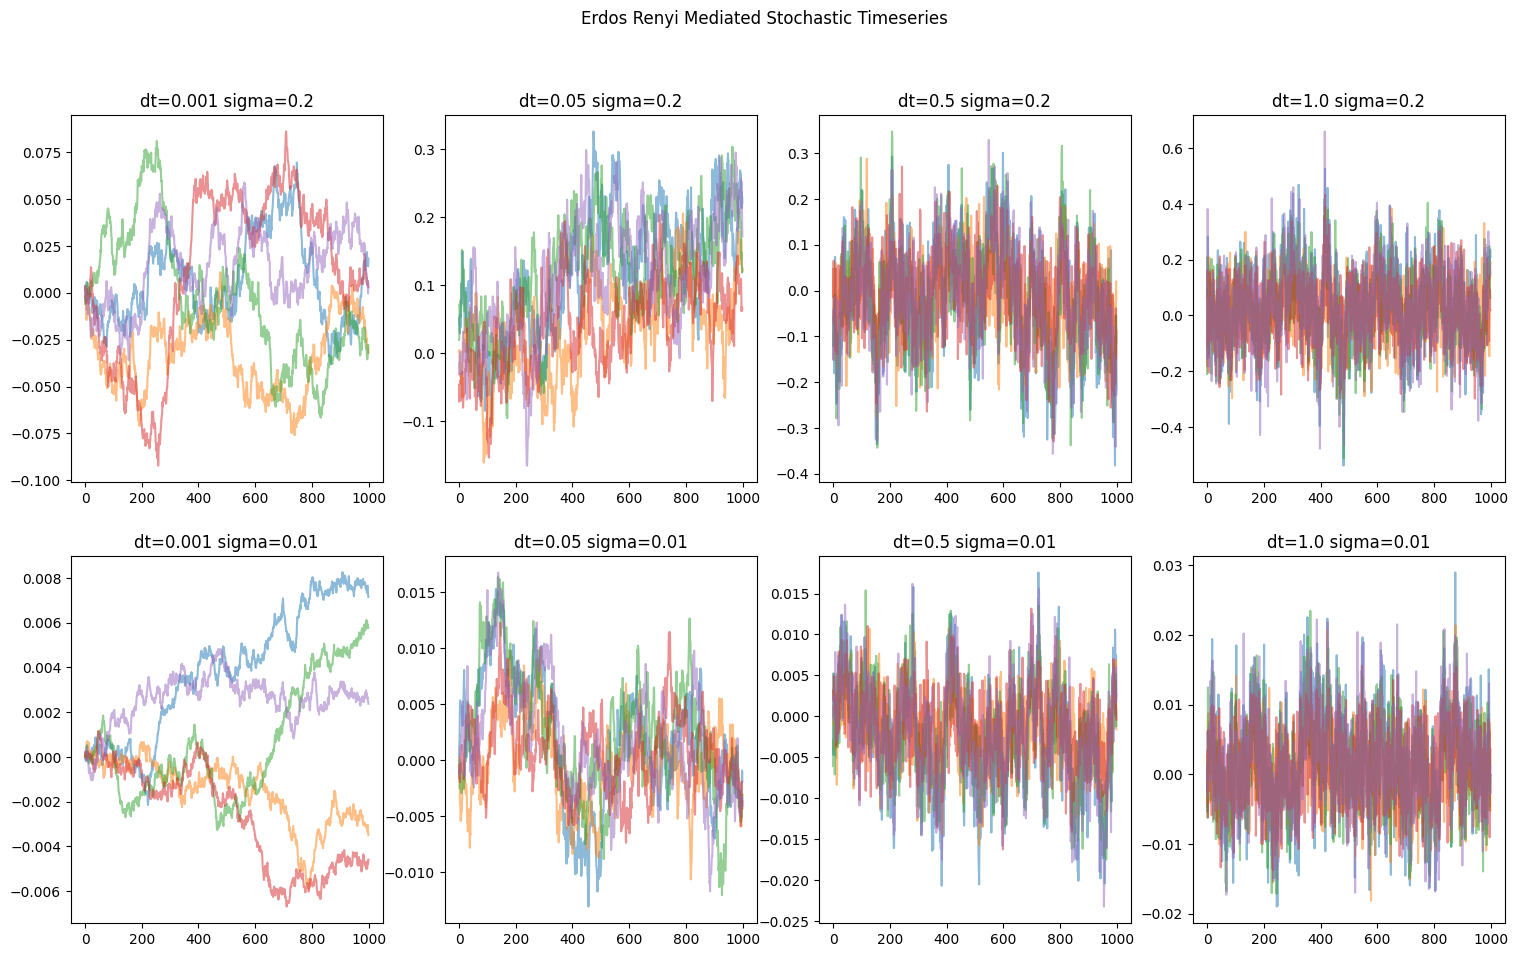

In [7]:
# Initialize an erdos-renyi adj matrix with desired mean degree
num_nodes = 5
mean_degree = 2
edge_prob = mean_degree / num_nodes
er = nx.erdos_renyi_graph(num_nodes, edge_prob)
adj = nx.adjacency_matrix(er).toarray()

# Plot

fig, ax = plt.subplots(2, 4)
dt_vals = [0.001, 0.05, 0.5, 1.0]
sigma_vals = [0.2, 0.01]

for j, dt in enumerate(dt_vals):
    for i, sig in enumerate(sigma_vals):
        # Simulate the time series as a stochastic process
        stochastic_timeseries = qspems_sim_core.sim(adj, dt=dt, sigma=sig)
        

        ax[i, j].plot(stochastic_timeseries.T, alpha=.5)
        ax[i, j].set_title(f"dt={dt} sigma={sig}")

fig.suptitle("Erdos Renyi Mediated Stochastic Timeseries")
fig.set_size_inches(18.5, 10.5)
plt.show()

In [8]:
num_edges = np.sum(adj == 1)

pred_adj = qspems.inf_via_LCRC(stochastic_timeseries, num_edges)

def compare_adj(adj, pred_adj):
    true_pos = np.sum((adj == 1) & (pred_adj == 1))
    true_neg = np.sum((adj == 0) & (pred_adj == 0))
    false_pos = np.sum((adj == 0) & (pred_adj == 1))
    false_neg = np.sum((adj == 1) & (pred_adj == 0))

    print(
        f"Predicted Adj Shape {pred_adj.shape} \n"
        f"True Adj Shape {adj.shape} \n"
        f"Number of edges: {num_edges} \n"
        f"True Pos: {true_pos} \t False Pos: {false_pos} \n"
        f"False Neg: {false_neg} \t True Neg: {true_neg}"
    )

compare_adj(adj, pred_adj)

Predicted Adj Shape (5, 5) 
True Adj Shape (5, 5) 
Number of edges: 10 
True Pos: 10 	 False Pos: 0 
False Neg: 0 	 True Neg: 15


### Exploring Multivariate Transfer Entropy

In [89]:
reshaped_timeseries = np.reshape(stochastic_timeseries, (5, 1000, 1))
data = Data(reshaped_timeseries)


# Initialize multivariate transfer entropy
network_analysis = MultivariateTE()
settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag_sources': 5,
            'min_lag_sources': 1}

# Infer network
results = network_analysis.analyse_network(settings=settings, data=data)

Adding data with properties: 5 processes, 1000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4]

Target: 0 - testing sources [1, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 2) 
maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
sele

In [90]:
mte_pred_adj = results.get_adjacency_matrix('binary').weight_matrix
compare_adj(adj, mte_pred_adj)

Predicted Adj Shape (5, 5) 
True Adj Shape (5, 5) 
Number of edges: 12 
True Pos: 12 	 False Pos: 0 
False Neg: 0 	 True Neg: 13


### Exploring Vector Autoregressive Models

In [16]:
var_model = VAR(stochastic_timeseries.T)
# The model accounts for five timesteps of lag,
# and has a constant has no trend.
result = var_model.fit(maxlags=4, verbose=True)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 20, Dec, 2022
Time:                     08:55:23
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -53.6724
Nobs:                     996.000    HQIC:                  -53.9928
Log likelihood:           20025.0    FPE:                2.92337e-24
AIC:                     -54.1893    Det(Omega_mle):     2.63376e-24
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000254         0.000153            1.667           0.096
L1.y1         0.031702         0.032009            0.990           0.322
L1.y2         0.437144         0.032830           13.315           0.000
L1.y3         0.398571

In [37]:
# I think the coefficient matrix is organized such that
# coefs[i, j, k] is the coefficient of the effect of
# y_{k+1}[n-(i + 1)] on y_{j+1}[n]

# We verify this by hand using the printout above
# This should describe the coefficient of the effect
# of y5[n-3] on y4[n] 
i = 2
j = 3
k = 4
print(f"Entry in coeff[{i}, {j}, {k}]: {result.coefs[i, j, k]}"
"\nCompared to table: 0.039118")

Entry in coeff[2, 3, 4]: 0.0391184102226586
Compared to table: 0.039118


In [47]:
# I think the p value matrix is organized such that
# the p-value of the effect of y_k[n-i] on y_j[n]
# is stored in pvals[(i - 1)*len(y) + k, j-1]

i = 3
j = 4
k = 5
len_y = 5
pval = result.pvalues[(i - 1) * len_y + k, j-1]
print(f"Entry in `pvalues[(i - 1) * len_y + k, j-1]`: {pval}"
"\nCompared to table: 0.311")

Entry in `pvalues[(i - 1) * len_y + k, j-1]`: 0.310867176325093
Compared to table: 0.311


In [48]:
result

In [72]:
def var_model_coeff_one_based(
    result: statsmodels.tsa.vector_ar.var_model.VARResultsWrapper,
    source_idx: int,
    target_idx: int,
    lag_in_source: int,
) -> float:
    """Returns the coefficient of the effect of
    `y_{source_idx}[n - lag_in_source]` on `y_{target_idx}[n]`
    where `n` is any arbitrary timestep.

    To correspond to the printout generated by `result.summary()`
    `source_idx`, `target_idx` and `lag_in_souce` are assumed to
    be one based.

    Parameters
    -----------
    result: The return value of statsmodels.ts.api.VAR.fit(...)
    source_idx: Which entry of y (the modeled time series vector)
        is the source of the effect. Assumed to be a one based index.
    target_idx: Which entry of y (the modeled time series vector)
        is impacted by the effect. Assumed to be a one based index.
    lag_in_source: The time lag that modifies the source index. Must
        be greater than zero.

    Returns
    -------
    The coefficient of the effect of
    `y_{source_idx}[n - lag_in_source]` on `y_{target_idx}[n]`
    where `n` is any arbitrary timestep.
    """
    return result.coefs[lag_in_source - 1, target_idx - 1, source_idx - 1]

def var_model_pval_one_based(
    result: statsmodels.tsa.vector_ar.var_model.VARResultsWrapper,
    source_idx: int,
    target_idx: int,
    lag_in_source: int,
) -> float:
    """Returns the p-value for the effect of
    `y_{source_idx}[n - lag_in_source]` on `y_{target_idx}[n]`
    where `n` is any arbitrary timestep.

    To correspond to the printout generated by `result.summary()`
    `source_idx`, `target_idx` and `lag_in_souce` are assumed to
    be one based.

    Parameters
    -----------
    result: The return value of statsmodels.ts.api.VAR.fit(...)
    source_idx: Which entry of y (the modeled time series vector)
        is the source of the effect. Assumed to be a one based index.
    target_idx: Which entry of y (the modeled time series vector)
        is impacted by the effect. Assumed to be a one based index.
    lag_in_source: The time lag that modifies the source index. Assumed
        to be one based. Must be greater than zero.

    Returns
    -------
    The p-value for the effect of
    `y_{source_idx}[n - lag_in_source]` on `y_{target_idx}[n]`
    where `n` is any arbitrary timestep.
    """
    return result.pvalues[(i - 1) * len_y + k, j-1]


## Applying Network Inference to Personal Health Dataset

In [91]:
df = pd.read_csv("~/Data/dj_health_data.csv")
# Encode days of the week as integers
df = df.replace(
    {
        "Monday": 1,
        "Tuesday": 2,
        "Wednesday": 3,
        "Thursday": 4,
        "Thurday": 4,
        "Friday": 5,
        "Saturday": 6,
        "Sunday": 7
    }
)

df = df.astype('float')

df = df.fillna(df.mean())

In [92]:
df.corr().style.background_gradient(cmap='coolwarm')

,Day,Day of Week,Hours of Sleep,Times woke up in night,How content did you feel when you went to sleep? (1-5),How much do you need to do tomorrow (1-5),Irritability (1-5),Screen time (1-5),How connected to children did you feel? (1-5),Escapism (1-5),How spacey were you? (1-5),Honest with self about feelings (1-5),Honesty with others about feelings (1-5),Exercise,Evening snacking,Self confidence (1-5),Socializing (1-5),Vulnerability with others (1-5),Loneliness (1-5),Fear (1-5)
Day,1.000000,0.035355,0.015272,-0.066373,-0.341235,-0.120542,-0.202690,0.109616,0.201622,-0.179001,0.046478,0.318222,-0.005022,-0.040825,-0.085147,0.238165,0.054704,-0.191740,0.371126,0.062378
Day of Week,0.035355,1.000000,0.013499,0.140389,-0.088955,-0.223238,0.367497,0.349742,0.080699,0.333087,0.154536,0.104881,-0.047351,0.144338,-0.186852,-0.179451,0.267793,0.010456,0.032286,0.022054
Hours of Sleep,0.015272,0.013499,1.000000,0.297329,0.029419,-0.000000,-0.097231,-0.050018,-0.071170,0.029375,0.000000,-0.201810,-0.250560,0.000000,0.109859,-0.292174,-0.059043,-0.225924,-0.028029,-0.058350
Times woke up in night,-0.066373,0.140389,0.297329,1.000000,-0.192065,-0.061821,0.078732,-0.013922,0.052227,-0.034937,0.071749,0.001915,0.026154,-0.082138,0.248804,-0.184834,-0.001992,0.051686,0.046102,0.081946
How content did you feel when you went to sleep? (1-5),-0.341235,-0.088955,0.029419,-0.192065,1.000000,-0.079432,-0.026697,0.001682,-0.151946,0.091852,-0.126874,-0.027141,0.098985,0.019259,-0.065562,-0.001228,-0.116461,0.110141,-0.337528,-0.210895
How much do you need to do tomorrow (1-5),-0.120542,-0.223238,-0.000000,-0.061821,-0.079432,1.000000,0.000000,-0.178404,-0.157768,-0.149617,0.092625,-0.097911,0.070151,0.038080,-0.095223,0.006723,-0.028079,0.017330,-0.081269,0.036253
Irritability (1-5),-0.202690,0.367497,-0.097231,0.078732,-0.026697,0.000000,1.000000,0.136171,-0.290634,0.213263,-0.185518,0.206032,0.198957,0.173276,-0.099695,-0.430859,-0.160741,0.251048,-0.077518,0.158854
Screen time (1-5),0.109616,0.349742,-0.050018,-0.013922,0.001682,-0.178404,0.136171,1.000000,-0.124083,0.169599,0.132368,-0.028840,-0.223794,0.221025,-0.117748,-0.090815,-0.013500,-0.180804,0.179449,0.296855
How connected to children did you feel? (1-5),0.201622,0.080699,-0.071170,0.052227,-0.151946,-0.157768,-0.290634,-0.124083,1.000000,0.042410,0.020927,0.167736,0.279584,-0.089300,-0.142969,0.163381,0.062831,0.160789,0.003990,-0.165515
Escapism (1-5),-0.179001,0.333087,0.029375,-0.034937,0.091852,-0.149617,0.213263,0.169599,0.042410,1.000000,0.213064,-0.164298,-0.012618,-0.099359,-0.241576,-0.213956,-0.106047,-0.094809,0.036228,0.208134


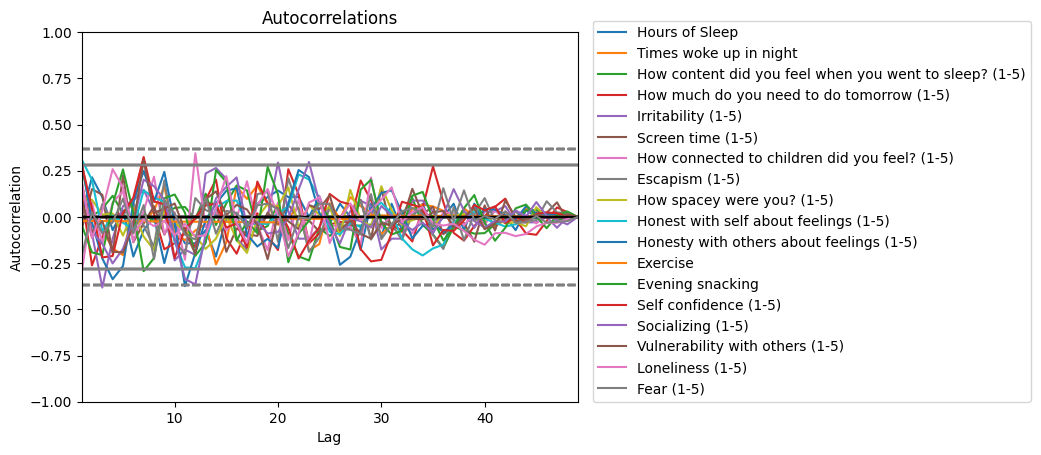

In [100]:
for c in df.columns:
    if c not in ["Day", "Day of Week"]:
        pd.plotting.autocorrelation_plot(df.loc[:, c], label=c)
    
    
plt.title(f"Autocorrelations")
plt.legend(loc=(1.03, 0.))

## Inferring computational network from health data using multivariate transfer entropy

In [104]:
reshaped_health_timeseries = np.reshape(df.values.T, (-1, 49, 1))
data = Data(reshaped_health_timeseries)


# Initialize multivariate transfer entropy
network_analysis = MultivariateTE()
settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag_sources': 5,
            'min_lag_sources': 1,
}

# Infer network
results = network_analysis.analyse_network(settings=settings, data=data)

Adding data with properties: 20 processes, 49 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), 

In [105]:
health_data_te_adj = results.get_adjacency_matrix('max_te_lag', fdr=False).weight_matrix
corr = df.corr()
corr.values[:, :] = health_data_te_adj[:, :]

corr.style.background_gradient(cmap='coolwarm')


,Day,Day of Week,Hours of Sleep,Times woke up in night,How content did you feel when you went to sleep? (1-5),How much do you need to do tomorrow (1-5),Irritability (1-5),Screen time (1-5),How connected to children did you feel? (1-5),Escapism (1-5),How spacey were you? (1-5),Honest with self about feelings (1-5),Honesty with others about feelings (1-5),Exercise,Evening snacking,Self confidence (1-5),Socializing (1-5),Vulnerability with others (1-5),Loneliness (1-5),Fear (1-5)
Day,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Day of Week,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
Hours of Sleep,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Times woke up in night,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
How content did you feel when you went to sleep? (1-5),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
How much do you need to do tomorrow (1-5),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Irritability (1-5),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Screen time (1-5),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
How connected to children did you feel? (1-5),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Escapism (1-5),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


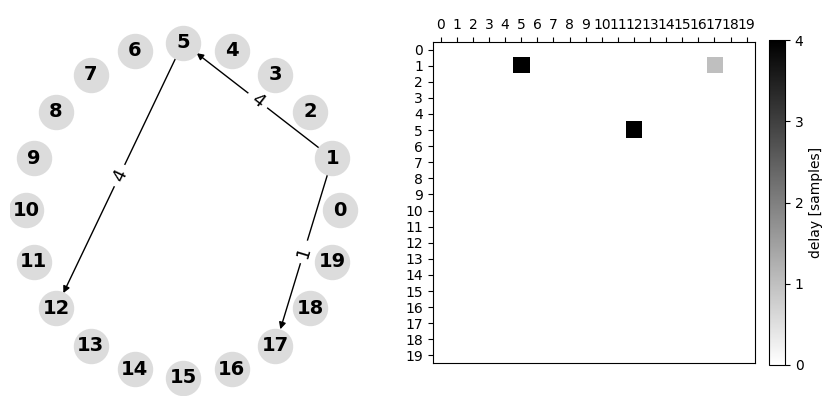

In [107]:
plot_network(results=results, weights='max_te_lag', fdr=False)
plt.show()

## Inferring network present in health data using lagged correlation

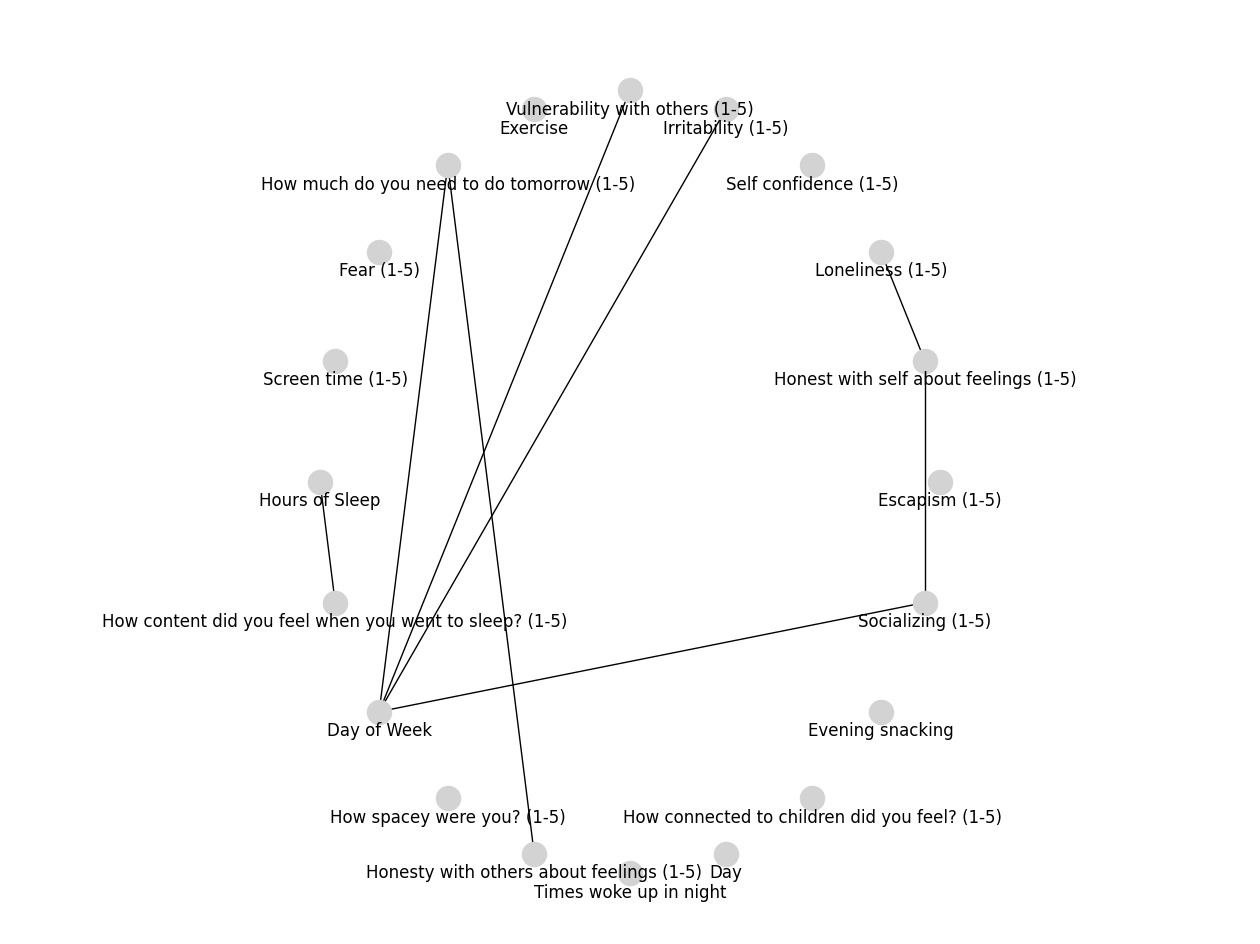

In [108]:
# Lagged correlation adj matrix
adj = qspems.inf_via_LCCF(df.values.T, 10, max_lag=10)
num_nodes = df.shape[1]

# Make graph
graph = nx.Graph(adj)

# Create empty figure
fig, ax = plt.subplots(figsize=(16, 12))

# Node positions
pos = nx.circular_layout(graph)
# Randomly permute node positions
perm = np.random.permutation(num_nodes)
perm_pos = {n:pos[perm[n]] for n in range(num_nodes)}

label_offset = (0.0, 0.05)
label_pos = {n:p - label_offset for n,p in perm_pos.items()}

# Draw graph
nx.draw(graph, pos=perm_pos, node_color="lightgray")

# Draw labels
nx.draw_networkx_labels(
    graph,
    label_pos,
    labels={
#        n:n for n in range(num_nodes)
        n:c for n, c in zip(range(num_nodes), df.columns)
    }
)

plt.xlim(-2, 2)
plt.show()

### Tests

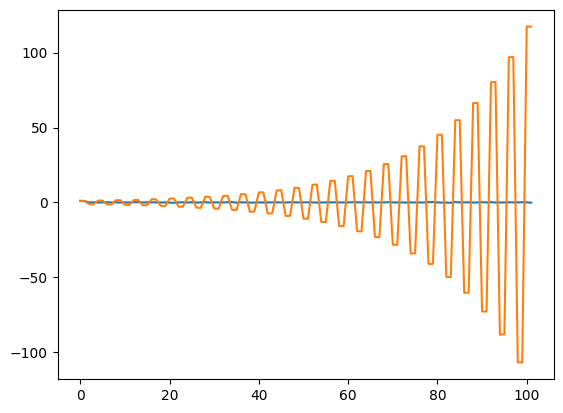

[[[ 3.15902873e-01 -4.99139441e-04]
  [ 1.89368438e+01  4.96558913e-02]]]
[[ 0.   0. ]
 [ 0.  -1.1]
 [ 0.   0. ]
 [ 0.   0. ]]


IndexError: index 1 is out of bounds for axis 0 with size 1

In [122]:
import unittest

class TestNetworkInferenceMethods(unittest.TestCase):
    
    def test_var_one_based(self):
        # Make a var model to generate a time series
        A = np.zeros((2, 4))
        # The only coefficient that matters is the effect of 
        # y_2[n-3] on y_2
        A[1,1] = -1.1
        Y = np.ones((4, 1))
        ts = np.reshape(Y, (2, -1))
        for i in range(100):
            Y_next = np.zeros_like(Y)
            Y_next[:2, :] = Y[2:]
            Y_next[2:, :] = A @ Y[:, -1:]
            ts = np.hstack((ts, Y_next[2:, :]))
            Y = Y_next

        ts += 0.1*np.random.randn(*ts.shape)
        plt.plot(ts.T)
        plt.show()
        var_model = VAR(ts.T)
        result = var_model.fit(maxlags=1)
        print(result.coefs)
        print(A.T)
        self.assertGreater(var_model_coeff_one_based(result, 2, 2, 2), 5)
        self.assertGreater(0.01, var_model_pval_one_based(result, 2, 2, 2))


tests = TestNetworkInferenceMethods()
tests.test_var_one_based()        
            